# 🚀 Accurate GSM Prediction: CatBoost + Optuna

## Objective
Achieve a Mean Absolute Error (MAE) of **≤ 5 GSM** on fabric samples using 64 extracted computer vision features.

## Dataset
Using the augmented dataset (~1000 samples) containing engineered features:
- `weft_count`, `warp_count` (Thread counting)
- `weft_spacing_avg`, `warp_spacing_avg` (Density)
- `yarn_avg_area`, `yarn_std_area` (Yarn properties)
- `texture_energy`, `texture_entropy` (Surface texture)
- Frequency domain features (FFT/Gabor filters)

## Methodology
1. **Load Data**: Use `dataset_train.csv`, `dataset_val.csv`, `dataset_test.csv` from the augmented features folder.
2. **Preprocessing**: Robust scaling to handle outliers.
3. **Model**: **CatBoost Regressor** (Gradient Boosting).
4. **Optimization**: **Optuna** for Bayesian hyperparameter tuning to minimize MAE.
5. **Evaluation**:
    - 5-Fold Cross-Validation.
    - Feature Importance Analysis (SHAP).
    - Error Analysis (Predicted vs Actual).

---

### 1. Setup & Environment

In [1]:
!pip install catboost optuna shap -q

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.preprocessing import RobustScaler
from catboost import CatBoostRegressor, Pool
import optuna
import shap
import warnings
import json

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✅ Libraries Installed & Imported")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 39.3 MB/s eta 0:00:00
✅ Libraries Installed & Imported


### 2. Data Loading
We load the augmented datasets which contain the 64 engineered features.

In [2]:
# Mount Google Drive (for Colab)
try:
    from google.colab import drive
    drive.mount('/content/drive')
    IN_COLAB = True
    BASE_PATH = '/content/drive/MyDrive/fabric_gsm_pipeline'
except:
    IN_COLAB = False
    BASE_PATH = 'data' # Change this to your local path if not in Colab
    print("Running locally")

# Dataset paths
DATASET_PATH = f"{BASE_PATH}/augmented_features_dataset"
TRAIN_CSV = f"{DATASET_PATH}/dataset_train.csv"
VAL_CSV = f"{DATASET_PATH}/dataset_val.csv"
TEST_CSV = f"{DATASET_PATH}/dataset_test.csv"

# Load Data
df_train = pd.read_csv(TRAIN_CSV)
df_val = pd.read_csv(VAL_CSV)
df_test = pd.read_csv(TEST_CSV)

# Combine Train and Val for Cross-Validation during tuning
df_train_full = pd.concat([df_train, df_val], axis=0).reset_index(drop=True)

print(f"Train samples: {len(df_train)}")
print(f"Val samples:   {len(df_val)}")
print(f"Test samples:  {len(df_test)}")
print(f"Total samples: {len(df_train_full) + len(df_test)}")

# Target Column
TARGET = 'gsm'

# Identify Features (exclude metadata)
meta_cols = ['image_name', 'gsm', 'source', 'augmentation', 'original_image', 'split']
features = [col for col in df_train.columns if col not in meta_cols]

print(f"\n🔬 Features used ({len(features)}): {features[:5]}...")

Mounted at /content/drive
Train samples: 738
Val samples:   156
Test samples:  168
Total samples: 1062

🔬 Features used (64): ['weft_count_autocorr', 'weft_count_fft', 'weft_count_direct', 'weft_count', 'weft_spacing_avg']...


### 3. Preprocessing
- **RobustScaler**: Used to scale features. It is robust to outliers which might be present in CV-extracted features.

In [3]:
# Initialize Scaler
scaler = RobustScaler()

# Fit on Full Train Set (Train + Val)
X = df_train_full[features]
y = df_train_full[TARGET]

X_test = df_test[features]
y_test = df_test[TARGET]

X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame for convenience with CatBoost (keeps column names)
X_scaled = pd.DataFrame(X_scaled, columns=features)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=features)

print("✅ Data Scaled using RobustScaler")

✅ Data Scaled using RobustScaler


### 4. Hyperparameter Tuning using Optuna
We use Optuna to find the best hyperparameters for CatBoost to minimize Mean Absolute Error (MAE).

In [11]:
# ============================================
# Optuna + CatBoost (GPU) — FIXED CELL
# ============================================

import optuna
from catboost import Pool, cv

def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 500, 2000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'depth': trial.suggest_int('depth', 4, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
        'random_strength': trial.suggest_float('random_strength', 1e-9, 10, log=True),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 1),
        'border_count': trial.suggest_int('border_count', 32, 255),

        # ---- REQUIRED & CORRECT ----
        'loss_function': 'MAE',
        'task_type': 'GPU',     # enable GPU
        'devices': '0',         # GPU 0 (string, NOT list)
        'random_seed': 42,
        'verbose': False
    }

    # Create CatBoost Pool
    cv_data = Pool(data=X_scaled, label=y)

    # 3-Fold CV
    scores = cv(
        pool=cv_data,
        params=params,
        fold_count=5,
        seed=42,
        shuffle=True,
        stratified=False,
        verbose=False
    )

    # Minimize validation MAE
    return scores['test-MAE-mean'].min()


print("⏳ Starting Optuna Optimization on GPU...")
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50, show_progress_bar=True)

print("\n🏆 Best Params:", study.best_params)
print("🏆 Best CV MAE:", study.best_value)


[I 2026-01-18 07:14:11,520] A new study created in memory with name: no-name-5d5fd049-7c74-4732-bdac-d37836efc74b


⏳ Starting Optuna Optimization on GPU...


  0%|          | 0/50 [00:00<?, ?it/s]

Training on fold [0/5]


Default metric period is 5 because MAE is/are not implemented for GPU


bestTest = 154.2258205
bestIteration = 759
Training on fold [1/5]
bestTest = 153.1624476
bestIteration = 759
Training on fold [2/5]
bestTest = 146.284076
bestIteration = 759
Training on fold [3/5]
bestTest = 152.0800454
bestIteration = 759
Training on fold [4/5]
bestTest = 148.6819149
bestIteration = 759
[I 2026-01-18 07:14:40,128] Trial 0 finished with value: 150.88686090356458 and parameters: {'iterations': 760, 'learning_rate': 0.015000418713095341, 'depth': 9, 'l2_leaf_reg': 8.826173559406449, 'random_strength': 0.007469767856900824, 'bagging_temperature': 0.7894872806812258, 'border_count': 233}. Best is trial 0 with value: 150.88686090356458.


Default metric period is 5 because MAE is/are not implemented for GPU


Training on fold [0/5]
bestTest = 46.11789674
bestIteration = 1076
Training on fold [1/5]
bestTest = 46.22813373
bestIteration = 1076
Training on fold [2/5]
bestTest = 39.11857051
bestIteration = 1076
Training on fold [3/5]
bestTest = 44.47141236
bestIteration = 1076
Training on fold [4/5]
bestTest = 41.70322375
bestIteration = 1076
[I 2026-01-18 07:16:22,616] Trial 1 finished with value: 43.52784741742711 and parameters: {'iterations': 1077, 'learning_rate': 0.23126372135925935, 'depth': 10, 'l2_leaf_reg': 6.344268703621775, 'random_strength': 5.2480003109339945e-09, 'bagging_temperature': 0.8442597177693784, 'border_count': 176}. Best is trial 1 with value: 43.52784741742711.


Default metric period is 5 because MAE is/are not implemented for GPU


Training on fold [0/5]
bestTest = 109.3249716
bestIteration = 1740
Training on fold [1/5]
bestTest = 108.6851759
bestIteration = 1740
Training on fold [2/5]
bestTest = 101.4859244
bestIteration = 1740
Training on fold [3/5]
bestTest = 107.6221194
bestIteration = 1740
Training on fold [4/5]
bestTest = 103.7059779
bestIteration = 1740
[I 2026-01-18 07:17:11,880] Trial 2 finished with value: 106.16483384399912 and parameters: {'iterations': 1741, 'learning_rate': 0.05934353106499811, 'depth': 4, 'l2_leaf_reg': 9.985527417659195, 'random_strength': 0.0038358171187622835, 'bagging_temperature': 0.15668257931783713, 'border_count': 68}. Best is trial 1 with value: 43.52784741742711.


Default metric period is 5 because MAE is/are not implemented for GPU


Training on fold [0/5]
bestTest = 20.2257346
bestIteration = 1216
Training on fold [1/5]
bestTest = 21.2904155
bestIteration = 1216
Training on fold [2/5]
bestTest = 16.79923594
bestIteration = 1216
Training on fold [3/5]
bestTest = 19.60649714
bestIteration = 1216
Training on fold [4/5]
bestTest = 19.22773108
bestIteration = 1216
[I 2026-01-18 07:17:55,746] Trial 3 finished with value: 19.429922853340184 and parameters: {'iterations': 1217, 'learning_rate': 0.29068942076396936, 'depth': 5, 'l2_leaf_reg': 1.3450842046862928, 'random_strength': 8.57745663565924, 'bagging_temperature': 0.38591957053073833, 'border_count': 176}. Best is trial 3 with value: 19.429922853340184.


Default metric period is 5 because MAE is/are not implemented for GPU


Training on fold [0/5]
bestTest = 57.03952078
bestIteration = 1454
Training on fold [1/5]
bestTest = 57.40853046
bestIteration = 1454
Training on fold [2/5]
bestTest = 48.76327361
bestIteration = 1454
Training on fold [3/5]
bestTest = 55.2230927
bestIteration = 1454
Training on fold [4/5]
bestTest = 51.33699087
bestIteration = 1454
[I 2026-01-18 07:19:24,057] Trial 4 finished with value: 53.954281684981325 and parameters: {'iterations': 1455, 'learning_rate': 0.14787089174724077, 'depth': 10, 'l2_leaf_reg': 5.986154973400557, 'random_strength': 0.10786778871490946, 'bagging_temperature': 0.2267570055472642, 'border_count': 198}. Best is trial 3 with value: 19.429922853340184.


Default metric period is 5 because MAE is/are not implemented for GPU


Training on fold [0/5]
bestTest = 20.58442356
bestIteration = 1725
Training on fold [1/5]
bestTest = 21.86547033
bestIteration = 1725
Training on fold [2/5]
bestTest = 17.20152649
bestIteration = 1725
Training on fold [3/5]
bestTest = 19.98053149
bestIteration = 1725
Training on fold [4/5]
bestTest = 19.58978203
bestIteration = 1725
[I 2026-01-18 07:20:33,251] Trial 5 finished with value: 19.844346779850902 and parameters: {'iterations': 1726, 'learning_rate': 0.19610964160916916, 'depth': 6, 'l2_leaf_reg': 1.0032496718937742, 'random_strength': 2.5550275001172744e-09, 'bagging_temperature': 0.003937622012781139, 'border_count': 189}. Best is trial 3 with value: 19.429922853340184.


Default metric period is 5 because MAE is/are not implemented for GPU


Training on fold [0/5]
bestTest = 90.94877139
bestIteration = 914
Training on fold [1/5]
bestTest = 90.34405552
bestIteration = 914
Training on fold [2/5]
bestTest = 82.99426065
bestIteration = 914
Training on fold [3/5]
bestTest = 89.07233109
bestIteration = 914
Training on fold [4/5]
bestTest = 85.39992429
bestIteration = 914
[I 2026-01-18 07:20:59,604] Trial 6 finished with value: 87.75186858684523 and parameters: {'iterations': 915, 'learning_rate': 0.1518881668471623, 'depth': 5, 'l2_leaf_reg': 3.1503853399905006, 'random_strength': 0.040249710138715866, 'bagging_temperature': 0.7886045598556984, 'border_count': 209}. Best is trial 3 with value: 19.429922853340184.


Default metric period is 5 because MAE is/are not implemented for GPU


Training on fold [0/5]
bestTest = 151.3352174
bestIteration = 1323
Training on fold [1/5]
bestTest = 150.3361448
bestIteration = 1323
Training on fold [2/5]
bestTest = 143.3969099
bestIteration = 1323
Training on fold [3/5]
bestTest = 149.221707
bestIteration = 1323
Training on fold [4/5]
bestTest = 145.7798675
bestIteration = 1323
[I 2026-01-18 07:21:38,978] Trial 7 finished with value: 148.01396930022443 and parameters: {'iterations': 1324, 'learning_rate': 0.013108842673712151, 'depth': 7, 'l2_leaf_reg': 9.278534707224154, 'random_strength': 1.3157641826102288e-05, 'bagging_temperature': 0.11414909630900438, 'border_count': 243}. Best is trial 3 with value: 19.429922853340184.


Default metric period is 5 because MAE is/are not implemented for GPU


Training on fold [0/5]
bestTest = 52.94716742
bestIteration = 1612
Training on fold [1/5]
bestTest = 52.53844601
bestIteration = 1612
Training on fold [2/5]
bestTest = 45.23913779
bestIteration = 1612
Training on fold [3/5]
bestTest = 51.38439464
bestIteration = 1612
Training on fold [4/5]
bestTest = 47.74744338
bestIteration = 1612
[I 2026-01-18 07:22:27,367] Trial 8 finished with value: 49.971317848750076 and parameters: {'iterations': 1613, 'learning_rate': 0.1429415252056654, 'depth': 5, 'l2_leaf_reg': 8.123072354044503, 'random_strength': 4.976696631340021, 'bagging_temperature': 0.4117235500366072, 'border_count': 125}. Best is trial 3 with value: 19.429922853340184.


Default metric period is 5 because MAE is/are not implemented for GPU


Training on fold [0/5]
bestTest = 17.28493393
bestIteration = 1742
Training on fold [1/5]
bestTest = 19.12295004
bestIteration = 1742
Training on fold [2/5]
bestTest = 14.37305506
bestIteration = 1742
Training on fold [3/5]
bestTest = 17.24026165
bestIteration = 1742
Training on fold [4/5]
bestTest = 16.70328136
bestIteration = 1742
[I 2026-01-18 07:24:35,405] Trial 9 finished with value: 16.944896408118407 and parameters: {'iterations': 1743, 'learning_rate': 0.215209194834209, 'depth': 8, 'l2_leaf_reg': 3.6399373257582006, 'random_strength': 1.356169228796385, 'bagging_temperature': 0.8760745270085292, 'border_count': 169}. Best is trial 9 with value: 16.944896408118407.


Default metric period is 5 because MAE is/are not implemented for GPU


Training on fold [0/5]
bestTest = 93.55764447
bestIteration = 1978
Training on fold [1/5]
bestTest = 92.59077121
bestIteration = 1978
Training on fold [2/5]
bestTest = 85.66767414
bestIteration = 1978
Training on fold [3/5]
bestTest = 91.57298577
bestIteration = 1978
Training on fold [4/5]
bestTest = 88.05700821
bestIteration = 1978
[I 2026-01-18 07:25:34,055] Trial 10 finished with value: 90.2892167602179 and parameters: {'iterations': 1979, 'learning_rate': 0.06756639658957177, 'depth': 8, 'l2_leaf_reg': 3.96806746271725, 'random_strength': 7.252222581094524e-07, 'bagging_temperature': 0.9587938336773488, 'border_count': 115}. Best is trial 9 with value: 16.944896408118407.


Default metric period is 5 because MAE is/are not implemented for GPU


Training on fold [0/5]
bestTest = 96.10941865
bestIteration = 514
Training on fold [1/5]
bestTest = 95.08205307
bestIteration = 514
Training on fold [2/5]
bestTest = 88.17502837
bestIteration = 514
Training on fold [3/5]
bestTest = 93.96429818
bestIteration = 514
Training on fold [4/5]
bestTest = 90.56180324
bestIteration = 514
[I 2026-01-18 07:25:52,803] Trial 11 finished with value: 92.77852030215266 and parameters: {'iterations': 515, 'learning_rate': 0.24849969840574287, 'depth': 7, 'l2_leaf_reg': 1.2821252072205944, 'random_strength': 7.891430722329041, 'bagging_temperature': 0.5513220132631345, 'border_count': 151}. Best is trial 9 with value: 16.944896408118407.


Default metric period is 5 because MAE is/are not implemented for GPU


Training on fold [0/5]
bestTest = 104.3664455
bestIteration = 1218
Training on fold [1/5]
bestTest = 103.3697735
bestIteration = 1218
Training on fold [2/5]
bestTest = 96.44520339
bestIteration = 1218
Training on fold [3/5]
bestTest = 102.3490529
bestIteration = 1218
Training on fold [4/5]
bestTest = 98.84878643
bestIteration = 1218
[I 2026-01-18 07:26:29,112] Trial 12 finished with value: 101.07585234517214 and parameters: {'iterations': 1219, 'learning_rate': 0.09175695260393436, 'depth': 8, 'l2_leaf_reg': 3.064988900789799, 'random_strength': 0.4745564299718037, 'bagging_temperature': 0.5392028019613424, 'border_count': 89}. Best is trial 9 with value: 16.944896408118407.


Default metric period is 5 because MAE is/are not implemented for GPU


Training on fold [0/5]
bestTest = 131.777682
bestIteration = 1980
Training on fold [1/5]
bestTest = 131.0307699
bestIteration = 1980
Training on fold [2/5]
bestTest = 123.8242842
bestIteration = 1980
Training on fold [3/5]
bestTest = 129.788997
bestIteration = 1980
Training on fold [4/5]
bestTest = 126.2355162
bestIteration = 1980
[I 2026-01-18 07:27:25,201] Trial 13 finished with value: 128.53144986092366 and parameters: {'iterations': 1981, 'learning_rate': 0.028652938492882984, 'depth': 4, 'l2_leaf_reg': 4.572879485877462, 'random_strength': 9.700058147461103e-05, 'bagging_temperature': 0.3728535045286835, 'border_count': 154}. Best is trial 9 with value: 16.944896408118407.


Default metric period is 5 because MAE is/are not implemented for GPU


Training on fold [0/5]
bestTest = 135.8098049
bestIteration = 1467
Training on fold [1/5]
bestTest = 134.7298141
bestIteration = 1467
Training on fold [2/5]
bestTest = 127.8742035
bestIteration = 1467
Training on fold [3/5]
bestTest = 133.6819352
bestIteration = 1467
Training on fold [4/5]
bestTest = 130.2662065
bestIteration = 1467
[I 2026-01-18 07:28:08,203] Trial 14 finished with value: 132.47239284600386 and parameters: {'iterations': 1468, 'learning_rate': 0.032983930403655125, 'depth': 6, 'l2_leaf_reg': 2.342203582141103, 'random_strength': 0.6756226565720023, 'bagging_temperature': 0.6527295076071921, 'border_count': 36}. Best is trial 9 with value: 16.944896408118407.


Default metric period is 5 because MAE is/are not implemented for GPU


Training on fold [0/5]
bestTest = 22.49444887
bestIteration = 1110
Training on fold [1/5]
bestTest = 24.26440839
bestIteration = 1110
Training on fold [2/5]
bestTest = 18.66859069
bestIteration = 1110
Training on fold [3/5]
bestTest = 21.9025156
bestIteration = 1110
Training on fold [4/5]
bestTest = 21.17250044
bestIteration = 1110
[I 2026-01-18 07:29:19,963] Trial 15 finished with value: 21.700492799023916 and parameters: {'iterations': 1111, 'learning_rate': 0.2971740139723076, 'depth': 8, 'l2_leaf_reg': 2.4781448763162492, 'random_strength': 0.0007793334125229861, 'bagging_temperature': 0.33956423255432755, 'border_count': 164}. Best is trial 9 with value: 16.944896408118407.


Default metric period is 5 because MAE is/are not implemented for GPU


Training on fold [0/5]
bestTest = 115.8270775
bestIteration = 895
Training on fold [1/5]
bestTest = 114.8426152
bestIteration = 895
Training on fold [2/5]
bestTest = 107.9294256
bestIteration = 895
Training on fold [3/5]
bestTest = 113.897881
bestIteration = 895
Training on fold [4/5]
bestTest = 110.3132242
bestIteration = 895
[I 2026-01-18 07:29:47,341] Trial 16 finished with value: 112.56204471627646 and parameters: {'iterations': 896, 'learning_rate': 0.09933579695993554, 'depth': 6, 'l2_leaf_reg': 4.260798882078582, 'random_strength': 4.773444545562287, 'bagging_temperature': 0.6505394616669278, 'border_count': 126}. Best is trial 9 with value: 16.944896408118407.


Default metric period is 5 because MAE is/are not implemented for GPU


Training on fold [0/5]
bestTest = 88.33600297
bestIteration = 1393
Training on fold [1/5]
bestTest = 87.87960457
bestIteration = 1393
Training on fold [2/5]
bestTest = 80.31449677
bestIteration = 1393
Training on fold [3/5]
bestTest = 86.49536269
bestIteration = 1393
Training on fold [4/5]
bestTest = 82.73192811
bestIteration = 1393
[I 2026-01-18 07:30:28,262] Trial 17 finished with value: 85.15147902232675 and parameters: {'iterations': 1394, 'learning_rate': 0.10442554013182957, 'depth': 7, 'l2_leaf_reg': 7.295254242161828, 'random_strength': 2.6703005717304303e-07, 'bagging_temperature': 0.9625216299724126, 'border_count': 209}. Best is trial 9 with value: 16.944896408118407.


Default metric period is 5 because MAE is/are not implemented for GPU


Training on fold [0/5]
bestTest = 130.5905966
bestIteration = 1620
Training on fold [1/5]
bestTest = 129.5941428
bestIteration = 1620
Training on fold [2/5]
bestTest = 122.6513181
bestIteration = 1620
Training on fold [3/5]
bestTest = 128.4721543
bestIteration = 1620
Training on fold [4/5]
bestTest = 125.0438575
bestIteration = 1620
[I 2026-01-18 07:31:33,965] Trial 18 finished with value: 127.27041387713027 and parameters: {'iterations': 1621, 'learning_rate': 0.03629442791358873, 'depth': 9, 'l2_leaf_reg': 1.872612214838667, 'random_strength': 0.28951176915807336, 'bagging_temperature': 0.670496146004744, 'border_count': 220}. Best is trial 9 with value: 16.944896408118407.


Default metric period is 5 because MAE is/are not implemented for GPU


Training on fold [0/5]
bestTest = 50.84983306
bestIteration = 1197
Training on fold [1/5]
bestTest = 51.05144684
bestIteration = 1197
Training on fold [2/5]
bestTest = 43.23747381
bestIteration = 1197
Training on fold [3/5]
bestTest = 49.04212312
bestIteration = 1197
Training on fold [4/5]
bestTest = 45.75053766
bestIteration = 1197
[I 2026-01-18 07:32:12,472] Trial 19 finished with value: 47.98628289822123 and parameters: {'iterations': 1198, 'learning_rate': 0.19592401991738048, 'depth': 5, 'l2_leaf_reg': 5.179242938834421, 'random_strength': 0.015678889885403523, 'bagging_temperature': 0.4569245849022152, 'border_count': 180}. Best is trial 9 with value: 16.944896408118407.


Default metric period is 5 because MAE is/are not implemented for GPU


Training on fold [0/5]
bestTest = 125.6701183
bestIteration = 1568
Training on fold [1/5]
bestTest = 124.6672268
bestIteration = 1568
Training on fold [2/5]
bestTest = 117.746312
bestIteration = 1568
Training on fold [3/5]
bestTest = 123.6244326
bestIteration = 1568
Training on fold [4/5]
bestTest = 120.1509831
bestIteration = 1568
[I 2026-01-18 07:33:04,810] Trial 20 finished with value: 122.37181455868276 and parameters: {'iterations': 1569, 'learning_rate': 0.04387488809698805, 'depth': 9, 'l2_leaf_reg': 3.469536430454931, 'random_strength': 0.0005374322824007279, 'bagging_temperature': 0.27542007184207534, 'border_count': 99}. Best is trial 9 with value: 16.944896408118407.


Default metric period is 5 because MAE is/are not implemented for GPU


Training on fold [0/5]
bestTest = 18.33037546
bestIteration = 1826
Training on fold [1/5]
bestTest = 19.51773088
bestIteration = 1826
Training on fold [2/5]
bestTest = 15.1386746
bestIteration = 1826
Training on fold [3/5]
bestTest = 17.93666528
bestIteration = 1826
Training on fold [4/5]
bestTest = 17.60200278
bestIteration = 1826
[I 2026-01-18 07:34:22,611] Trial 21 finished with value: 17.70508980102424 and parameters: {'iterations': 1827, 'learning_rate': 0.1945042806866144, 'depth': 6, 'l2_leaf_reg': 1.174637074959218, 'random_strength': 5.3507830016949226e-09, 'bagging_temperature': 0.0085770339969794, 'border_count': 189}. Best is trial 9 with value: 16.944896408118407.


Default metric period is 5 because MAE is/are not implemented for GPU


Training on fold [0/5]
bestTest = 8.124799505
bestIteration = 1837
Training on fold [1/5]
bestTest = 8.989445351
bestIteration = 1837
Training on fold [2/5]
bestTest = 6.703669884
bestIteration = 1837
Training on fold [3/5]
bestTest = 8.950691777
bestIteration = 1837
Training on fold [4/5]
bestTest = 8.704524008
bestIteration = 1837
[I 2026-01-18 07:35:47,405] Trial 22 finished with value: 8.294626104862376 and parameters: {'iterations': 1838, 'learning_rate': 0.26701015890348373, 'depth': 6, 'l2_leaf_reg': 1.8961588106215979, 'random_strength': 5.947110471446713e-08, 'bagging_temperature': 0.001589488005638259, 'border_count': 171}. Best is trial 22 with value: 8.294626104862376.


Default metric period is 5 because MAE is/are not implemented for GPU


Training on fold [0/5]
bestTest = 24.59132496
bestIteration = 1844
Training on fold [1/5]
bestTest = 25.90782396
bestIteration = 1844
Training on fold [2/5]
bestTest = 20.29833439
bestIteration = 1844
Training on fold [3/5]
bestTest = 23.7185536
bestIteration = 1844
Training on fold [4/5]
bestTest = 22.95236926
bestIteration = 1844
[I 2026-01-18 07:37:01,526] Trial 23 finished with value: 23.493681232676757 and parameters: {'iterations': 1845, 'learning_rate': 0.174987901008934, 'depth': 6, 'l2_leaf_reg': 2.2512209374444163, 'random_strength': 2.6785278523463166e-08, 'bagging_temperature': 0.03810165887453078, 'border_count': 139}. Best is trial 22 with value: 8.294626104862376.


Default metric period is 5 because MAE is/are not implemented for GPU


Training on fold [0/5]
bestTest = 51.79162666
bestIteration = 1850
Training on fold [1/5]
bestTest = 50.97423839
bestIteration = 1850
Training on fold [2/5]
bestTest = 44.38353265
bestIteration = 1850
Training on fold [3/5]
bestTest = 49.65666463
bestIteration = 1850
Training on fold [4/5]
bestTest = 46.73611965
bestIteration = 1850
[I 2026-01-18 07:38:08,459] Trial 24 finished with value: 48.708436394156834 and parameters: {'iterations': 1851, 'learning_rate': 0.12205043768776987, 'depth': 7, 'l2_leaf_reg': 1.8813992864523703, 'random_strength': 5.038435386135138e-08, 'bagging_temperature': 0.07684265197609175, 'border_count': 168}. Best is trial 22 with value: 8.294626104862376.


Default metric period is 5 because MAE is/are not implemented for GPU


Training on fold [0/5]
bestTest = 84.35282821
bestIteration = 1842
Training on fold [1/5]
bestTest = 84.09084759
bestIteration = 1842
Training on fold [2/5]
bestTest = 76.39171068
bestIteration = 1842
Training on fold [3/5]
bestTest = 82.23941603
bestIteration = 1842
Training on fold [4/5]
bestTest = 78.84646024
bestIteration = 1842
[I 2026-01-18 07:39:06,470] Trial 25 finished with value: 81.18425254809804 and parameters: {'iterations': 1843, 'learning_rate': 0.08251871026961159, 'depth': 8, 'l2_leaf_reg': 2.75269551406031, 'random_strength': 3.9647671286515715e-06, 'bagging_temperature': 0.13931095342755656, 'border_count': 252}. Best is trial 22 with value: 8.294626104862376.


Default metric period is 5 because MAE is/are not implemented for GPU


Training on fold [0/5]
bestTest = 18.49249847
bestIteration = 1695
Training on fold [1/5]
bestTest = 21.20792734
bestIteration = 1695
Training on fold [2/5]
bestTest = 15.50005183
bestIteration = 1695
Training on fold [3/5]
bestTest = 18.65841999
bestIteration = 1695
Training on fold [4/5]
bestTest = 17.64295257
bestIteration = 1695
[I 2026-01-18 07:40:16,835] Trial 26 finished with value: 18.300370039091924 and parameters: {'iterations': 1696, 'learning_rate': 0.21700736509542082, 'depth': 6, 'l2_leaf_reg': 3.7127088022664405, 'random_strength': 1.2710684005829437e-09, 'bagging_temperature': 0.19540151209619572, 'border_count': 194}. Best is trial 22 with value: 8.294626104862376.


Default metric period is 5 because MAE is/are not implemented for GPU


Training on fold [0/5]
bestTest = 139.662644
bestIteration = 1864
Training on fold [1/5]
bestTest = 138.6729225
bestIteration = 1864
Training on fold [2/5]
bestTest = 131.7100209
bestIteration = 1864
Training on fold [3/5]
bestTest = 137.7051763
bestIteration = 1864
Training on fold [4/5]
bestTest = 134.1475487
bestIteration = 1864
[I 2026-01-18 07:41:11,415] Trial 27 finished with value: 136.37966250205966 and parameters: {'iterations': 1865, 'learning_rate': 0.021864777845671646, 'depth': 7, 'l2_leaf_reg': 4.979953880243215, 'random_strength': 2.1044428905012317e-08, 'bagging_temperature': 0.068976525908615, 'border_count': 144}. Best is trial 22 with value: 8.294626104862376.


Default metric period is 5 because MAE is/are not implemented for GPU


Training on fold [0/5]
bestTest = 47.66598289
bestIteration = 1997
Training on fold [1/5]
bestTest = 47.19294475
bestIteration = 1997
Training on fold [2/5]
bestTest = 40.71762341
bestIteration = 1997
Training on fold [3/5]
bestTest = 45.71416725
bestIteration = 1997
Training on fold [4/5]
bestTest = 43.12957558
bestIteration = 1997
[I 2026-01-18 07:42:21,309] Trial 28 finished with value: 44.88405877421576 and parameters: {'iterations': 1998, 'learning_rate': 0.11930777715111326, 'depth': 6, 'l2_leaf_reg': 1.6186973884845781, 'random_strength': 2.0694915234169664e-07, 'bagging_temperature': 0.2883305150256745, 'border_count': 224}. Best is trial 22 with value: 8.294626104862376.


Default metric period is 5 because MAE is/are not implemented for GPU


Training on fold [0/5]
bestTest = 151.9813853
bestIteration = 1540
Training on fold [1/5]
bestTest = 150.9162557
bestIteration = 1540
Training on fold [2/5]
bestTest = 144.0400663
bestIteration = 1540
Training on fold [3/5]
bestTest = 149.8324459
bestIteration = 1540
Training on fold [4/5]
bestTest = 146.4398481
bestIteration = 1540
[I 2026-01-18 07:43:17,443] Trial 29 finished with value: 148.64200026677545 and parameters: {'iterations': 1541, 'learning_rate': 0.01024785155918802, 'depth': 9, 'l2_leaf_reg': 2.9958284344323136, 'random_strength': 5.258701871613211e-06, 'bagging_temperature': 0.8418302248501981, 'border_count': 232}. Best is trial 22 with value: 8.294626104862376.


Default metric period is 5 because MAE is/are not implemented for GPU


Training on fold [0/5]
bestTest = 27.93002575
bestIteration = 1764
Training on fold [1/5]
bestTest = 29.10974598
bestIteration = 1764
Training on fold [2/5]
bestTest = 23.4505472
bestIteration = 1764
Training on fold [3/5]
bestTest = 27.02268462
bestIteration = 1764
Training on fold [4/5]
bestTest = 26.09552482
bestIteration = 1764
[I 2026-01-18 07:45:06,632] Trial 30 finished with value: 26.721705675427426 and parameters: {'iterations': 1765, 'learning_rate': 0.17143323396393234, 'depth': 8, 'l2_leaf_reg': 1.768031357643244, 'random_strength': 0.00011684548853589193, 'bagging_temperature': 0.7226371506711365, 'border_count': 206}. Best is trial 22 with value: 8.294626104862376.


Default metric period is 5 because MAE is/are not implemented for GPU


Training on fold [0/5]
bestTest = 13.99120957
bestIteration = 1691
Training on fold [1/5]
bestTest = 16.52427494
bestIteration = 1691
Training on fold [2/5]
bestTest = 11.49766362
bestIteration = 1691
Training on fold [3/5]
bestTest = 14.90623091
bestIteration = 1691
Training on fold [4/5]
bestTest = 14.16223556
bestIteration = 1691
[I 2026-01-18 07:46:18,581] Trial 31 finished with value: 14.216322919445577 and parameters: {'iterations': 1692, 'learning_rate': 0.24249746112606962, 'depth': 6, 'l2_leaf_reg': 3.806203163744868, 'random_strength': 1.8585891638512974e-09, 'bagging_temperature': 0.19678154495831368, 'border_count': 182}. Best is trial 22 with value: 8.294626104862376.


Default metric period is 5 because MAE is/are not implemented for GPU


Training on fold [0/5]
bestTest = 16.54787475
bestIteration = 1664
Training on fold [1/5]
bestTest = 19.42692148
bestIteration = 1664
Training on fold [2/5]
bestTest = 13.75440544
bestIteration = 1664
Training on fold [3/5]
bestTest = 17.45350962
bestIteration = 1664
Training on fold [4/5]
bestTest = 15.87672819
bestIteration = 1664
[I 2026-01-18 07:47:20,183] Trial 32 finished with value: 16.61188789680399 and parameters: {'iterations': 1665, 'learning_rate': 0.2451827052093889, 'depth': 5, 'l2_leaf_reg': 5.822259914504671, 'random_strength': 7.956527478715713e-09, 'bagging_temperature': 0.043248011566326475, 'border_count': 165}. Best is trial 22 with value: 8.294626104862376.


Default metric period is 5 because MAE is/are not implemented for GPU


Training on fold [0/5]
bestTest = 17.98933419
bestIteration = 1693
Training on fold [1/5]
bestTest = 20.41088049
bestIteration = 1693
Training on fold [2/5]
bestTest = 14.70163288
bestIteration = 1693
Training on fold [3/5]
bestTest = 18.75423632
bestIteration = 1693
Training on fold [4/5]
bestTest = 17.24859276
bestIteration = 1693
[I 2026-01-18 07:48:14,978] Trial 33 finished with value: 17.82093532754535 and parameters: {'iterations': 1694, 'learning_rate': 0.2484259766219448, 'depth': 4, 'l2_leaf_reg': 6.5527767680406015, 'random_strength': 7.855874436186156e-09, 'bagging_temperature': 0.19297430886675465, 'border_count': 167}. Best is trial 22 with value: 8.294626104862376.


Default metric period is 5 because MAE is/are not implemented for GPU


Training on fold [0/5]
bestTest = 20.12396888
bestIteration = 1490
Training on fold [1/5]
bestTest = 22.90380314
bestIteration = 1490
Training on fold [2/5]
bestTest = 16.68221074
bestIteration = 1490
Training on fold [3/5]
bestTest = 20.02866675
bestIteration = 1490
Training on fold [4/5]
bestTest = 18.84801286
bestIteration = 1490
[I 2026-01-18 07:49:08,956] Trial 34 finished with value: 19.71733247334207 and parameters: {'iterations': 1491, 'learning_rate': 0.2509442574957377, 'depth': 5, 'l2_leaf_reg': 5.754328810532008, 'random_strength': 5.586657287629416e-08, 'bagging_temperature': 0.10550202871581278, 'border_count': 156}. Best is trial 22 with value: 8.294626104862376.


Default metric period is 5 because MAE is/are not implemented for GPU


Training on fold [0/5]
bestTest = 14.24152191
bestIteration = 1645
Training on fold [1/5]
bestTest = 16.45970452
bestIteration = 1645
Training on fold [2/5]
bestTest = 11.6485548
bestIteration = 1645
Training on fold [3/5]
bestTest = 15.3185776
bestIteration = 1645
Training on fold [4/5]
bestTest = 14.63005014
bestIteration = 1645
[I 2026-01-18 07:50:03,566] Trial 35 finished with value: 14.45968179485457 and parameters: {'iterations': 1646, 'learning_rate': 0.2875289737872554, 'depth': 4, 'l2_leaf_reg': 6.719715471332227, 'random_strength': 1.241853580093354e-09, 'bagging_temperature': 0.24628030674707707, 'border_count': 180}. Best is trial 22 with value: 8.294626104862376.


Default metric period is 5 because MAE is/are not implemented for GPU


Training on fold [0/5]
bestTest = 19.49741265
bestIteration = 1367
Training on fold [1/5]
bestTest = 22.33885491
bestIteration = 1367
Training on fold [2/5]
bestTest = 16.05905339
bestIteration = 1367
Training on fold [3/5]
bestTest = 19.5989015
bestIteration = 1367
Training on fold [4/5]
bestTest = 18.65698791
bestIteration = 1367
[I 2026-01-18 07:50:47,306] Trial 36 finished with value: 19.23024207360551 and parameters: {'iterations': 1368, 'learning_rate': 0.294352512941188, 'depth': 4, 'l2_leaf_reg': 6.769693510314397, 'random_strength': 1.2780329162451598e-09, 'bagging_temperature': 0.25747384368984505, 'border_count': 185}. Best is trial 22 with value: 8.294626104862376.


Default metric period is 5 because MAE is/are not implemented for GPU


Training on fold [0/5]
bestTest = 46.37628753
bestIteration = 1633
Training on fold [1/5]
bestTest = 46.17796351
bestIteration = 1633
Training on fold [2/5]
bestTest = 39.54261959
bestIteration = 1633
Training on fold [3/5]
bestTest = 45.00320793
bestIteration = 1633
Training on fold [4/5]
bestTest = 41.96582031
bestIteration = 1633
[I 2026-01-18 07:51:37,424] Trial 37 finished with value: 43.8131797747905 and parameters: {'iterations': 1634, 'learning_rate': 0.15548194482948283, 'depth': 4, 'l2_leaf_reg': 7.397300083307551, 'random_strength': 9.90350207712386e-09, 'bagging_temperature': 0.17224856504486702, 'border_count': 142}. Best is trial 22 with value: 8.294626104862376.


Default metric period is 5 because MAE is/are not implemented for GPU


Training on fold [0/5]
bestTest = 12.70197931
bestIteration = 1908
Training on fold [1/5]
bestTest = 15.46769979
bestIteration = 1908
Training on fold [2/5]
bestTest = 10.87177503
bestIteration = 1908
Training on fold [3/5]
bestTest = 14.21128257
bestIteration = 1908
Training on fold [4/5]
bestTest = 13.77799936
bestIteration = 1908
[I 2026-01-18 07:52:47,722] Trial 38 finished with value: 13.406147211448493 and parameters: {'iterations': 1909, 'learning_rate': 0.23909983858150763, 'depth': 5, 'l2_leaf_reg': 6.212077368462296, 'random_strength': 1.2776963317465002e-07, 'bagging_temperature': 0.32150392902726094, 'border_count': 179}. Best is trial 22 with value: 8.294626104862376.


Default metric period is 5 because MAE is/are not implemented for GPU


Training on fold [0/5]
bestTest = 46.7284447
bestIteration = 1915
Training on fold [1/5]
bestTest = 47.52492144
bestIteration = 1915
Training on fold [2/5]
bestTest = 39.54750786
bestIteration = 1915
Training on fold [3/5]
bestTest = 45.14066592
bestIteration = 1915
Training on fold [4/5]
bestTest = 42.20687215
bestIteration = 1915
[I 2026-01-18 07:53:49,825] Trial 39 finished with value: 44.22968241214063 and parameters: {'iterations': 1916, 'learning_rate': 0.13177589857184832, 'depth': 5, 'l2_leaf_reg': 8.432537682001712, 'random_strength': 8.013482726850076e-07, 'bagging_temperature': 0.3172110441315934, 'border_count': 202}. Best is trial 22 with value: 8.294626104862376.


Default metric period is 5 because MAE is/are not implemented for GPU


Training on fold [0/5]
bestTest = 32.23376397
bestIteration = 1781
Training on fold [1/5]
bestTest = 34.29291419
bestIteration = 1781
Training on fold [2/5]
bestTest = 26.99129823
bestIteration = 1781
Training on fold [3/5]
bestTest = 31.21232324
bestIteration = 1781
Training on fold [4/5]
bestTest = 29.35445927
bestIteration = 1781
[I 2026-01-18 07:54:45,372] Trial 40 finished with value: 30.81695177886275 and parameters: {'iterations': 1782, 'learning_rate': 0.17308297124657757, 'depth': 4, 'l2_leaf_reg': 6.138923694761981, 'random_strength': 1.1390718457467503e-07, 'bagging_temperature': 0.23676399523467875, 'border_count': 178}. Best is trial 22 with value: 8.294626104862376.


Default metric period is 5 because MAE is/are not implemented for GPU


Training on fold [0/5]
bestTest = 11.45464986
bestIteration = 1911
Training on fold [1/5]
bestTest = 13.72200157
bestIteration = 1911
Training on fold [2/5]
bestTest = 9.356767878
bestIteration = 1911
Training on fold [3/5]
bestTest = 12.68191614
bestIteration = 1911
Training on fold [4/5]
bestTest = 12.03201397
bestIteration = 1911
[I 2026-01-18 07:55:56,123] Trial 41 finished with value: 11.849469881834159 and parameters: {'iterations': 1912, 'learning_rate': 0.2507005283319226, 'depth': 5, 'l2_leaf_reg': 5.5484935582207875, 'random_strength': 2.891651085129726e-09, 'bagging_temperature': 0.14246364518800975, 'border_count': 174}. Best is trial 22 with value: 8.294626104862376.


Default metric period is 5 because MAE is/are not implemented for GPU


Training on fold [0/5]
bestTest = 7.759604683
bestIteration = 1945
Training on fold [1/5]
bestTest = 9.64034267
bestIteration = 1945
Training on fold [2/5]
bestTest = 6.312021266
bestIteration = 1945
Training on fold [3/5]
bestTest = 9.270651705
bestIteration = 1945
Training on fold [4/5]
bestTest = 8.668371994
bestIteration = 1945
[I 2026-01-18 07:57:16,610] Trial 42 finished with value: 8.33019846360133 and parameters: {'iterations': 1946, 'learning_rate': 0.29414797362031964, 'depth': 5, 'l2_leaf_reg': 5.326063140236464, 'random_strength': 2.8898535221427124e-09, 'bagging_temperature': 0.14732738194952638, 'border_count': 195}. Best is trial 22 with value: 8.294626104862376.


Default metric period is 5 because MAE is/are not implemented for GPU


Training on fold [0/5]
bestTest = 15.41206982
bestIteration = 1915
Training on fold [1/5]
bestTest = 18.14611885
bestIteration = 1915
Training on fold [2/5]
bestTest = 13.02955602
bestIteration = 1915
Training on fold [3/5]
bestTest = 16.6946169
bestIteration = 1915
Training on fold [4/5]
bestTest = 15.38564618
bestIteration = 1915
[I 2026-01-18 07:58:27,227] Trial 43 finished with value: 15.733601553427672 and parameters: {'iterations': 1916, 'learning_rate': 0.21677516311306913, 'depth': 5, 'l2_leaf_reg': 5.245291392128102, 'random_strength': 3.922140711253883e-09, 'bagging_temperature': 0.13857743551454765, 'border_count': 214}. Best is trial 22 with value: 8.294626104862376.


Default metric period is 5 because MAE is/are not implemented for GPU


Training on fold [0/5]
bestTest = 9.700169398
bestIteration = 1908
Training on fold [1/5]
bestTest = 12.01826281
bestIteration = 1908
Training on fold [2/5]
bestTest = 7.947893025
bestIteration = 1908
Training on fold [3/5]
bestTest = 11.13501659
bestIteration = 1908
Training on fold [4/5]
bestTest = 10.38318008
bestIteration = 1908
[I 2026-01-18 07:59:53,127] Trial 44 finished with value: 10.236904380242335 and parameters: {'iterations': 1909, 'learning_rate': 0.2524349670465678, 'depth': 6, 'l2_leaf_reg': 4.619738595360001, 'random_strength': 1.848137372729219e-08, 'bagging_temperature': 0.09991414572727886, 'border_count': 197}. Best is trial 22 with value: 8.294626104862376.


Default metric period is 5 because MAE is/are not implemented for GPU


Training on fold [0/5]
bestTest = 19.9133369
bestIteration = 1936
Training on fold [1/5]
bestTest = 22.70067677
bestIteration = 1936
Training on fold [2/5]
bestTest = 16.59231516
bestIteration = 1936
Training on fold [3/5]
bestTest = 19.86052478
bestIteration = 1936
Training on fold [4/5]
bestTest = 18.80919724
bestIteration = 1936
[I 2026-01-18 08:01:01,747] Trial 45 finished with value: 19.57521017150132 and parameters: {'iterations': 1937, 'learning_rate': 0.19312624432377987, 'depth': 5, 'l2_leaf_reg': 5.510204616887263, 'random_strength': 5.502074074392438e-07, 'bagging_temperature': 0.1073681724391755, 'border_count': 197}. Best is trial 22 with value: 8.294626104862376.


Default metric period is 5 because MAE is/are not implemented for GPU


Training on fold [0/5]
bestTest = 7.629742329
bestIteration = 1915
Training on fold [1/5]
bestTest = 9.102012592
bestIteration = 1915
Training on fold [2/5]
bestTest = 6.258912497
bestIteration = 1915
Training on fold [3/5]
bestTest = 8.667505019
bestIteration = 1915
Training on fold [4/5]
bestTest = 8.031800002
bestIteration = 1915
[I 2026-01-18 08:02:17,340] Trial 46 finished with value: 7.937994487825426 and parameters: {'iterations': 1916, 'learning_rate': 0.2998735991009905, 'depth': 5, 'l2_leaf_reg': 4.7051330993484815, 'random_strength': 2.0879910771751723e-08, 'bagging_temperature': 0.0023504386383841613, 'border_count': 228}. Best is trial 46 with value: 7.937994487825426.


Default metric period is 5 because MAE is/are not implemented for GPU


Training on fold [0/5]
bestTest = 9.014462945
bestIteration = 1793
Training on fold [1/5]
bestTest = 11.2735848
bestIteration = 1793
Training on fold [2/5]
bestTest = 7.460113014
bestIteration = 1793
Training on fold [3/5]
bestTest = 10.30495687
bestIteration = 1793
Training on fold [4/5]
bestTest = 9.555703838
bestIteration = 1793
[I 2026-01-18 08:03:38,949] Trial 47 finished with value: 9.521764294616727 and parameters: {'iterations': 1794, 'learning_rate': 0.2800042347114674, 'depth': 6, 'l2_leaf_reg': 4.686870747562101, 'random_strength': 1.809644700597547e-08, 'bagging_temperature': 0.011795488295017946, 'border_count': 235}. Best is trial 46 with value: 7.937994487825426.


Default metric period is 5 because MAE is/are not implemented for GPU


Training on fold [0/5]
bestTest = 8.673292107
bestIteration = 1781
Training on fold [1/5]
bestTest = 11.0301425
bestIteration = 1781
Training on fold [2/5]
bestTest = 7.316486721
bestIteration = 1781
Training on fold [3/5]
bestTest = 10.03497212
bestIteration = 1781
Training on fold [4/5]
bestTest = 9.256147406
bestIteration = 1781
[I 2026-01-18 08:05:00,142] Trial 48 finished with value: 9.262208171420895 and parameters: {'iterations': 1782, 'learning_rate': 0.2859664884853869, 'depth': 6, 'l2_leaf_reg': 4.730138503970177, 'random_strength': 2.123556577158743e-08, 'bagging_temperature': 0.014288453545148044, 'border_count': 243}. Best is trial 46 with value: 7.937994487825426.


Default metric period is 5 because MAE is/are not implemented for GPU


Training on fold [0/5]
bestTest = 8.912318054
bestIteration = 1773
Training on fold [1/5]
bestTest = 11.18580534
bestIteration = 1773
Training on fold [2/5]
bestTest = 7.380803455
bestIteration = 1773
Training on fold [3/5]
bestTest = 10.02225635
bestIteration = 1773
Training on fold [4/5]
bestTest = 9.209594041
bestIteration = 1773
[I 2026-01-18 08:06:21,370] Trial 49 finished with value: 9.342155447252262 and parameters: {'iterations': 1774, 'learning_rate': 0.28439231086767824, 'depth': 6, 'l2_leaf_reg': 4.568504236494067, 'random_strength': 1.5458587140835778e-06, 'bagging_temperature': 0.0054184571947855035, 'border_count': 244}. Best is trial 46 with value: 7.937994487825426.

🏆 Best Params: {'iterations': 1916, 'learning_rate': 0.2998735991009905, 'depth': 5, 'l2_leaf_reg': 4.7051330993484815, 'random_strength': 2.0879910771751723e-08, 'bagging_temperature': 0.0023504386383841613, 'border_count': 228}
🏆 Best CV MAE: 7.937994487825426


### 5. Final Model Training
Train variables on the full training set using the best parameters found.

In [12]:
# ============================================
# Final CatBoost Training on GPU (FIXED)
# ============================================

from catboost import CatBoostRegressor

# -----------------------------
# Prepare Best Parameters
# -----------------------------
best_params = study.best_params.copy()

best_params['loss_function'] = 'MAE'
best_params['random_seed'] = 42
best_params['task_type'] = 'GPU'   # Enable GPU
best_params['devices'] = '0'       # GPU 0 (string, safe)
best_params['verbose'] = 100

# -----------------------------
# Train Final Model
# -----------------------------
model = CatBoostRegressor(**best_params)

model.fit(
    X_scaled,
    y,
    eval_set=(X_test_scaled, y_test),
    early_stopping_rounds=50,
    verbose=100
)

print("\n✅ Model Training Completed on GPU")


Default metric period is 5 because MAE is/are not implemented for GPU


0:	learn: 39.1271934	test: 31.8403785	best: 31.8403785 (0)	total: 12.1ms	remaining: 23.1s
100:	learn: 30.7514091	test: 26.3245239	best: 26.3245239 (100)	total: 866ms	remaining: 15.6s
200:	learn: 24.5422325	test: 22.3688122	best: 22.3688122 (200)	total: 1.62s	remaining: 13.8s
300:	learn: 19.3957722	test: 19.3546520	best: 19.3546520 (300)	total: 2.36s	remaining: 12.7s
400:	learn: 14.8904262	test: 17.2050374	best: 17.2050374 (400)	total: 3.61s	remaining: 13.7s
500:	learn: 11.5838402	test: 16.2381272	best: 16.2338998 (498)	total: 5.16s	remaining: 14.6s
600:	learn: 9.6053726	test: 15.5285964	best: 15.5204352 (599)	total: 6.54s	remaining: 14.3s
700:	learn: 8.1006837	test: 15.0565331	best: 15.0565331 (700)	total: 7.33s	remaining: 12.7s
800:	learn: 6.8068886	test: 14.5431896	best: 14.5431896 (800)	total: 8.09s	remaining: 11.3s
900:	learn: 5.6822092	test: 14.0757068	best: 14.0757068 (900)	total: 8.83s	remaining: 9.95s
1000:	learn: 4.7383086	test: 13.5371152	best: 13.5371152 (1000)	total: 9.59s	

### 6. Evaluation on Test Set
Checking if we met the **MAE ≤ 5** criteria.

🧪 FINAL TEST RESULTS
MAE:  11.7434 GSM
RMSE: 16.8603 GSM
R²:   0.8759
⚠️ WARNING: MAE 11.74 is above ±5 target.


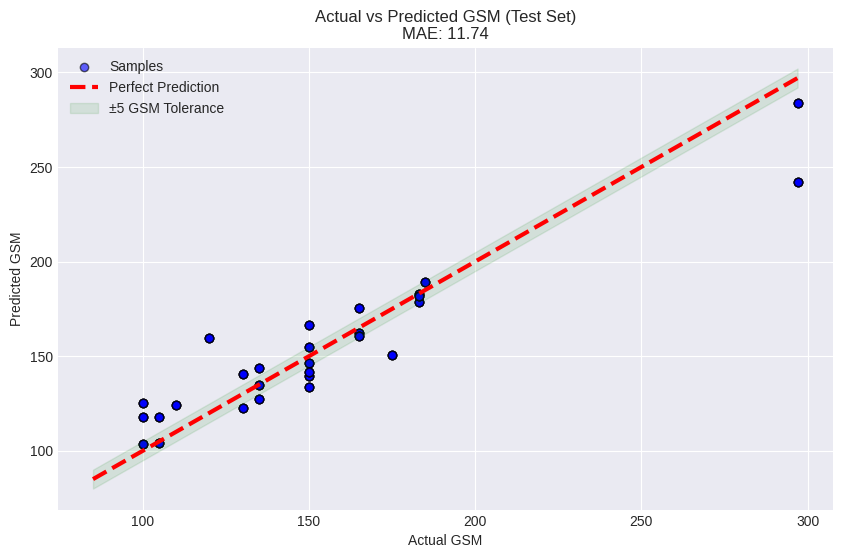

In [13]:
# Predictions
y_pred = model.predict(X_test_scaled)

# Metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("="*40)
print("🧪 FINAL TEST RESULTS")
print("="*40)
print(f"MAE:  {mae:.4f} GSM")
print(f"RMSE: {rmse:.4f} GSM")
print(f"R²:   {r2:.4f}")
print("="*40)

# Success Check
if mae <= 5.0:
    print("🎉 SUCCESS: MAE is within ±5 GSM target!")
else:
    print(f"⚠️ WARNING: MAE {mae:.2f} is above ±5 target.")

# Visualizing Predictions
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.6, color='blue', edgecolor='k', label='Samples')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=3, label='Perfect Prediction')

# Tolerance Band
plt.fill_between([y.min(), y.max()],
                 [y.min()-5, y.max()-5],
                 [y.min()+5, y.max()+5],
                 color='green', alpha=0.1, label='±5 GSM Tolerance')

plt.xlabel('Actual GSM')
plt.ylabel('Predicted GSM')
plt.title(f'Actual vs Predicted GSM (Test Set)\nMAE: {mae:.2f}')
plt.legend()
plt.show()

### 7. Feature Importance Analysis
Understanding what drives the predictions (Physics check).

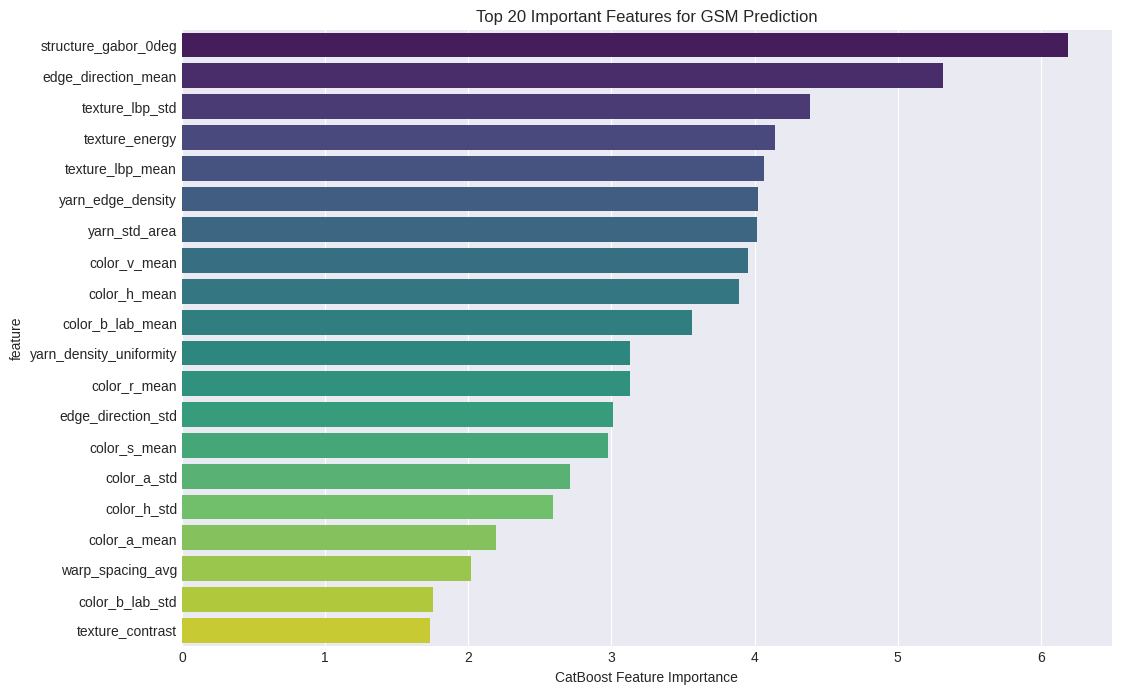

In [14]:
feature_importances = model.get_feature_importance()
feature_names = X_scaled.columns

# Create DataFrame
fi_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
fi_df = fi_df.sort_values(by='importance', ascending=False).head(20)

# Plot
plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=fi_df, palette='viridis')
plt.title('Top 20 Important Features for GSM Prediction')
plt.xlabel('CatBoost Feature Importance')
plt.show()

### 8. Save Model
Saving the trained model for future inference.

In [15]:
model_save_path = "catboost_gsm_model2.cbm"
model.save_model(model_save_path)
print(f"✅ Model saved to {model_save_path}")

✅ Model saved to catboost_gsm_model2.cbm


📄 CSV Columns:
['image_name', 'gsm', 'source', 'weft_count_autocorr', 'weft_count_fft', 'weft_count_direct', 'weft_count', 'weft_spacing_avg', 'weft_spacing_std', 'weft_spacing_cv', 'weft_confidence', 'warp_count_autocorr', 'warp_count_fft', 'warp_count_direct', 'warp_count', 'warp_spacing_avg', 'warp_spacing_std', 'warp_spacing_cv', 'warp_confidence', 'yarn_edge_density', 'yarn_component_count', 'yarn_avg_area', 'yarn_std_area', 'yarn_density_uniformity', 'weft_spacing_uniformity', 'weft_lines_detected', 'warp_spacing_uniformity', 'warp_lines_detected', 'texture_contrast', 'texture_homogeneity', 'texture_energy', 'texture_entropy', 'texture_lbp_mean', 'texture_lbp_std', 'freq_dc_component', 'freq_high_freq_energy', 'freq_low_freq_energy', 'freq_radial_peak', 'structure_gabor_0deg', 'structure_gabor_45deg', 'structure_gabor_90deg', 'structure_gabor_135deg', 'structure_dominant_orientation', 'structure_regularity', 'edge_gradient_mean', 'edge_gradient_std', 'edge_direction_mean', 'edge_

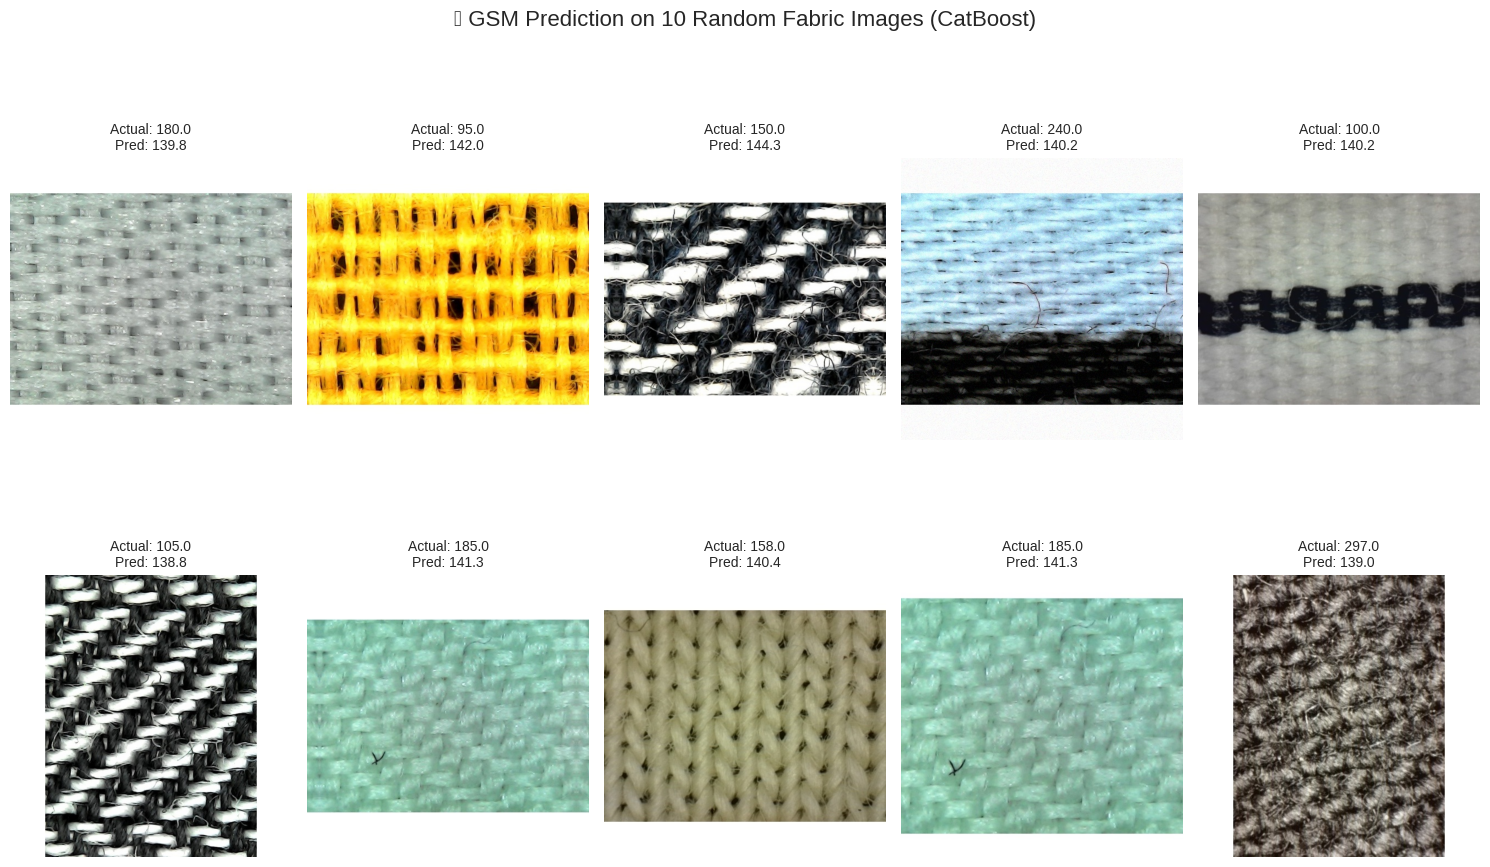


📋 Actual vs Predicted GSM

fabricnet_0127.jpg             | Actual: 180.00 | Predicted: 139.78 | Error: 40.22
fabricnet_0096_aug_3_horizontal_flip.jpg | Actual:  95.00 | Predicted: 142.05 | Error: 47.05
fabricnet_0105_aug_4_zoom_out.jpg | Actual: 150.00 | Predicted: 144.33 | Error:  5.67
fabricnet_0100_aug_4_gaussian_noise.jpg | Actual: 240.00 | Predicted: 140.18 | Error: 99.82
gsm_manual_0147.jpg            | Actual: 100.00 | Predicted: 140.17 | Error: 40.17
fabricnet_0039_aug_5_rotate_90.jpg | Actual: 105.00 | Predicted: 138.80 | Error: 33.80
fabricnet_0116_aug_4_zoom_out.jpg | Actual: 185.00 | Predicted: 141.28 | Error: 43.72
gsm_manual_0158.jpg            | Actual: 158.00 | Predicted: 140.36 | Error: 17.64
fabricnet_0116_aug_3_zoom_in.jpg | Actual: 185.00 | Predicted: 141.28 | Error: 43.72
gsm_manual_0164_aug_1_rotate_270.jpg | Actual: 297.00 | Predicted: 138.98 | Error: 158.02


In [21]:
# ============================================
# GSM Prediction on 10 Random Images (CatBoost)
# FIX: Drop non-numeric features
# ============================================

import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt

# -----------------------------
# USER CONFIG
# -----------------------------
NUM_SAMPLES = 10

CSV_PATH = "/content/drive/MyDrive/fabric_gsm_pipeline/augmented_features_dataset/dataset_val.csv"
IMAGE_ROOT = "/content/drive/MyDrive/fabric_gsm_pipeline/augmented_features_dataset/images"

TARGET_COL = "gsm"

# -----------------------------
# Load Dataset
# -----------------------------
df = pd.read_csv(CSV_PATH)

print("📄 CSV Columns:")
print(df.columns.tolist())

# -----------------------------
# Auto-detect image column
# -----------------------------
possible_image_cols = [
    "image_path", "image", "img", "filename", "file", "path", "image_name"
]

image_col = None
for col in possible_image_cols:
    if col in df.columns:
        image_col = col
        break

if image_col is None:
    raise ValueError("❌ Image column not found")

print(f"✅ Image column detected: {image_col}")

# -----------------------------
# Keep ONLY numeric feature columns
# -----------------------------
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

if TARGET_COL not in numeric_cols:
    raise ValueError("❌ Target column not numeric")

# Remove target from features
feature_cols = [c for c in numeric_cols if c != TARGET_COL]

print(f"🧮 Using {len(feature_cols)} numeric features")

# -----------------------------
# Sample data
# -----------------------------
sample_df = df.sample(NUM_SAMPLES, random_state=42).reset_index(drop=True)

X_sample = sample_df[feature_cols]
y_actual = sample_df[TARGET_COL].values
image_paths = sample_df[image_col].values

# -----------------------------
# Predict GSM (CatBoost)
# -----------------------------
y_pred = model.predict(X_sample)

# -----------------------------
# Display Images + GSM
# -----------------------------
plt.figure(figsize=(15, 10))

for i in range(NUM_SAMPLES):
    img_path = f"{IMAGE_ROOT}/{image_paths[i]}"
    img = cv2.imread(img_path)

    if img is None:
        print(f"⚠️ Missing image: {img_path}")
        continue

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.subplot(2, 5, i + 1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(
        f"Actual: {y_actual[i]:.1f}\nPred: {y_pred[i]:.1f}",
        fontsize=10
    )

plt.suptitle("📊 GSM Prediction on 10 Random Fabric Images (CatBoost)", fontsize=16)
plt.tight_layout()
plt.show()

# -----------------------------
# Print Table
# -----------------------------
print("\n📋 Actual vs Predicted GSM\n")
for i in range(NUM_SAMPLES):
    print(
        f"{image_paths[i]:30s} | "
        f"Actual: {y_actual[i]:6.2f} | "
        f"Predicted: {y_pred[i]:6.2f} | "
        f"Error: {abs(y_actual[i] - y_pred[i]):5.2f}"
    )
